In [11]:
import sys
import os
sys.path.append(os.path.abspath("../"))

import pandas as pd
import utils
# Mining: multidupehack
# Plotting
import plot_automations as plotter

Loïc Cerf and Wagner Meira Jr. Complete Discovery of High-Quality Patterns in Large Numerical Tensors. In ICDE'14: Proceedings of the 30th International Conference on Data Engineering, pages 448–459. IEEE Computer Society, April 2014.

**1. Multidupehack input file**

In [12]:
df = pd.read_csv("../01_artwork_clustering/omniart-post-artwork-clustering.csv")

In [13]:
artwork_clusters = pd.read_csv("../01_artwork_clustering/artwork-centroids.csv")

In [14]:
utils.prepare_multidupehack_input(df, "decade", "decade_mining.txt")

**2. Itemset mining**

In [5]:
patterns_df = utils.parse_patterns("decade_patterns.txt", "decades")

In [6]:
patterns_df

,decades,clusters,n_decades,n_clusters,support
0,"[1940, 1850, 1910, 1950, 1890, 2010, 2000]","[67, 57, 40, 5, 90, 54, 98, 49, 73, 87, 64, 74...",7,86,602
1,"[1940, 2000, 1910, 1950, 1890, 2010]","[67, 57, 2, 40, 5, 90, 54, 98, 49, 73, 87, 64,...",6,88,528
2,"[1940, 1850, 1930, 1900, 1910, 1950, 1890, 201...","[67, 40, 5, 90, 54, 98, 49, 73, 87, 64, 74, 96...",9,85,765
3,"[1940, 2000, 1930, 1900, 1910, 1950, 1890, 2010]","[67, 2, 40, 5, 90, 54, 98, 49, 73, 87, 64, 74,...",8,87,696
4,"[1930, 1850, 1900, 1910, 1890, 2010, 2000]","[67, 51, 40, 5, 90, 54, 98, 49, 73, 87, 64, 74...",7,86,602
...,...,...,...,...,...
1471228,"[1170, -50, 1180, 1090, 1260, 1280, 1250, 1100...","[48, 15]",82,2,164
1471229,"[1160, 890, 820, 590, 960, 1250, 1270, 1350, 1...","[75, 59]",77,2,154
1471230,"[820, 590, 750, 1120, 1190, 960, 1180, 1260, 1...","[75, 14]",84,2,168
1471231,"[870, 970, 750, 1120, 1150, 1180, 1260, 1200, ...","[15, 14]",84,2,168


Plot saved to images/decade_patterns_per_support_count.png


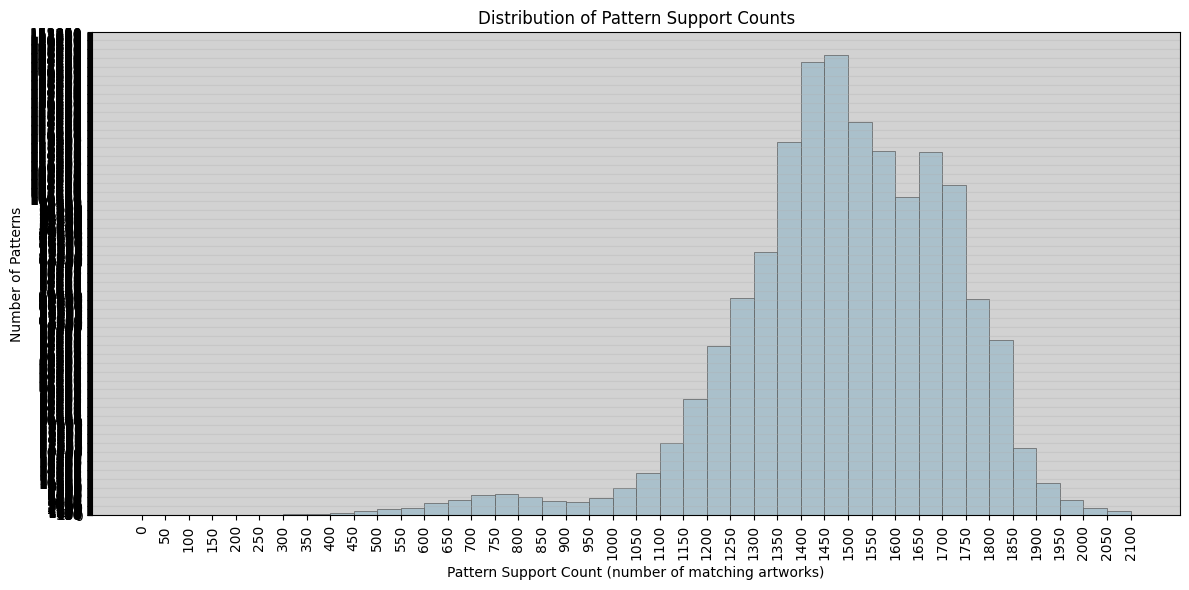

In [7]:
plotter.plot_support_analysis(patterns_df, "images/decade_patterns_per_support_count.png")

Plot saved to images/decade_n_decades_per_pattern.png


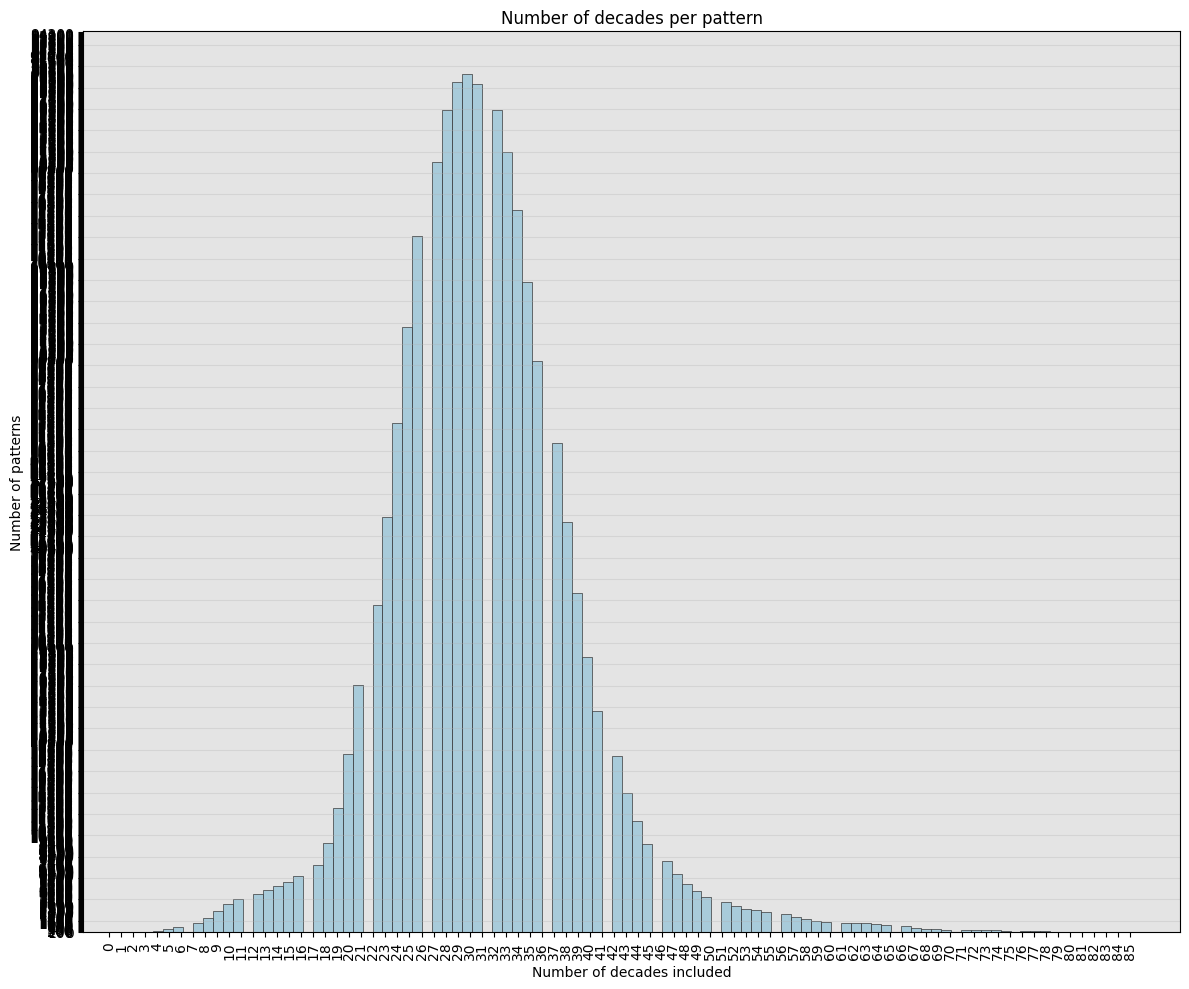

In [8]:
plotter.plot_pattern_size_distribution(patterns_df, "decades", "images/decade_n_decades_per_pattern.png")

In [9]:
plotter.plot_pattern_size_distribution(patterns_df, "colors", "images/decade_n_colors_per_pattern.png")

KeyError: 'n_colors'

<Figure size 1200x1000 with 0 Axes>

In [ ]:
plotter.plot_temporal_patterns(patterns_df, "images/decade_pattern_frequency_by_starting_decade.png")

In [ ]:
plotter.plot_color_cooccurrence_matrix(patterns_df, save_path="images/decade_color_cooccurrence_matrix.png")

In [ ]:
patterns_df['decades_range'] = patterns_df['decades'].apply(
    lambda x: f"{min(int(d) for d in x)}-{max(int(d) for d in x)}" 
    if min(int(d) for d in x) != max(int(d) for d in x) 
    else str(min(int(d) for d in x))
)

In [ ]:
aggregated_patterns_df = patterns_df.groupby('decades_range').apply(lambda x: pd.Series({
    'decades': list(set([item for sublist in x['decades'] for item in sublist])),
    'colors': list(set([item for sublist in x['colors'] for item in sublist])),
    'colors_names': list(set([item for sublist in x['colors_names'] for item in sublist])),
    'n_decades': len(list(set([item for sublist in x['decades'] for item in sublist]))),
    'n_colors': len(list(set([item for sublist in x['colors'] for item in sublist]))),
    'support': x['support'].max()
})).reset_index()

In [ ]:
aggregated_patterns_df.to_csv("weighted_decade_mining.csv", index=False)

In [ ]:
unique_decade_ranges = patterns_df['decades_range'].unique()

In [ ]:
unique_decade_ranges

In [ ]:
for decade_range in unique_decade_ranges:
    plotter.plot_color_grid(patterns_df, "decades", decade_range, save_path=f"images/color_palettes/{decade_range}.png")